## Introduction
The purpose of this notebook is to develop a hueristic extraction method for sentences prescribing some allowable action, i.e., 'permission statments' from a corpus of informed consent forms. These extractions are to be evaluated using human annotators. From these evalutations we will develop a text classifier to automate the process of permission extraction.

### Authors: Cooper Stansbury

## Set-up and Notebook Configuration

In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.0


In [2]:
# Fundamentals
import os
import re
import pandas as pd
import numpy as np
from itertools import chain
import csv
import datetime
import collections
from collections import defaultdict

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# zoomies
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

# NLP and related tools
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

# custom data functions
import load_data
import clean_data

/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

## Semantic Clues
These are the verbs that we believe indicate the prescence of a statement of 'allowable action.'

Taken from: 

```
“I found synonyms for ‘permission’ on the new Thesaurus.com!,”
www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
[Accessed: 19-Feb-2019].
```

In [4]:
semantic_bases = ["permission", 
                "authorization", 
                "authorize",
                "consent",
                "assent",
                "permit",
                "approve",
                "agree",
                "grant",
                "allow",
                "certify"]

## Print Base Definitions

In [5]:
def printWordNetDefinitions(wordList):
    """ return wordnet definitions for a given list """
    
    for word in wordList:
        syns = wordnet.synsets(word)
        print(word, ":")
        count = 0
        for word_sense in syns:
            count += 1
            print("  ", count, ":", word_sense.definition())
    

In [6]:
# printWordNetDefinitions(semantic_bases)

## Add Synonyms
Use WordNet to gather synonyms of the semantic clues.

In [7]:
def addWordNetSynsets(word_list):
    """  add synsets to new list """
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        
        v_synonyms = wordnet.synsets(word, "v")
        v_synonyms = set(chain.from_iterable([word.lemma_names() for word in v_synonyms]))
        
        [updated_list.append(x) for x in v_synonyms if x not in updated_list]
        
    print('Found: ', len(set(updated_list)), ' total clues')
    return set(updated_list)

In [8]:
%%time
# expect 65
extended_semantic_clues = addWordNetSynsets(semantic_bases)

Found:  65  total clues
CPU times: user 1.72 s, sys: 75.1 ms, total: 1.79 s
Wall time: 1.85 s


## Check Clue Similarities
Turns out not to be very helpful, likely because those words that aren't, on average, as similar have more definitions than those like 'permit,' which have only a few specified uses in the English language, this is evidenced in the standard deviations.

In [9]:
# clue_similarity_matrix = pd.DataFrame(index=extended_semantic_clues, 
#                                       columns=extended_semantic_clues)

# for index, row in clue_similarity_matrix.iterrows():
#     for base in extended_semantic_clues:
#         base_syn = wordnet.synsets(base)
#         index_syn = wordnet.synsets(index)
#         sim = wordnet.wup_similarity(index_syn[0], base_syn[0])
        
#         if sim != None:
#             row[base] = wordnet.wup_similarity(index_syn[0], base_syn[0])
#         else:
#             row[base] = 0.0
        
# clue_similarity_matrix = clue_similarity_matrix.astype(float)

Unfortunately, this doesn't help us automate 'culling' of terms we don't really like.

In [10]:
# clue_similarity_matrix.describe(include = 'all').transpose().sort_values('mean', ascending = False)

In [11]:
# %matplotlib inline

# mask = np.zeros_like(clue_similarity_matrix, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(25, 15), facecolor='w')
# cmap = sns.diverging_palette(230, 90, as_cmap=True)

# sns.heatmap(clue_similarity_matrix, 
#             mask=mask, 
#             cmap=cmap, 
#             vmax=1, 
#             center=0,
#             square=True, 
#             linewidths=1, 
#             cbar_kws={"shrink": .5})

## Remove Inapproriate Clues

Here we define a list of terms we will remove from the semantic clues.

In [12]:
"""
Define a list to remove selected words from the semantic clues. 
WordNet has it's weaknesses.
"""
poorly_fitting_semantic_clues = {
     'manifest',
     'harmonise',
     'gibe',
     'harmonize',
     'yield',
     'allot',
     'demonstrate',
     'endorse',
     'take_into_account',
     'allow_for',
     'set_aside',
     'clear',
     'acquiesce',
     'indorse',
     'go_for',
     'earmark',
     'license',
     'reserve',
     'pass',
     'tolerate',
     'O.K.',
     'deed_over',
     'award',
     'evidence',
     'appropriate',
     'leave',
     'give_up',
     'empower',
     'okay',
     'countenance',
     'fit_in',
     'correspond',
     'hold',
     'concord',
     'match',
     'jibe',
     'fit',
     'tally',
     'consort',
}

In [13]:
# XOR power
permission_extended = list(poorly_fitting_semantic_clues ^ extended_semantic_clues)

In [14]:
# expect 26
print('num terms after culling: ', len(permission_extended), '\n')

num terms after culling:  26 



Let's check the definitions, just to make sure we agree that each clue belongs. Note, at this points we aren't using each definition (or word sense for the clue). We are only performing string matching with the semantic clue. We just want a sanity check here.

In [15]:
printWordNetDefinitions(permission_extended)

approve :
   1 : give sanction to
   2 : judge to be right or commendable; think well of
authorize :
   1 : grant authorization or clearance for
   2 : give or delegate power or authority to
admit :
   1 : declare to be true or admit the existence or reality or truth of
   2 : allow to enter; grant entry to
   3 : allow participation in or the right to be part of; permit to exercise the rights, functions, and responsibilities of
   4 : admit into a group or community
   5 : afford possibility
   6 : give access or entrance to
   7 : have room for; hold without crowding
   8 : serve as a means of entrance
licence :
   1 : excessive freedom; lack of due restraint
   2 : freedom to deviate deliberately from normally applicable rules or practices (especially in behavior or speech)
   3 : a legal document giving official permission to do something
   4 : authorize officially
cede :
   1 : give over; surrender or relinquish to the physical control of another
   2 : relinquish possession or c

## Import Data
Det dataframe for each consent for in `data/`

In [16]:
# Data location
forms_dir = '../data/raw/all_forms'

In [17]:
%%time

"""
NOTE: running this cell will re-load the data in the dataframe from the dir.
"""
# run the function and store to variable 
raw_df = load_data.getDIRData(forms_dir)

# set the index as the id, for future access
raw_df = raw_df.set_index('id')

CPU times: user 144 ms, sys: 97.8 ms, total: 242 ms
Wall time: 370 ms


In [18]:
raw_df.head()

,name,path,rawText
id,,,
1,TAMU - HRPP Informed consent.txt,../data/raw/all_forms/TAMU - HRPP Informed con...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...
2,Potomac Primary Care_flu-consent-form.txt,../data/raw/all_forms/Potomac Primary Care_flu...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...
3,OSU_Scheduled_Delivery_Consent.txt,../data/raw/all_forms/OSU_Scheduled_Delivery_C...,SCHEDULED DELIVERY: Today’s Date: Da...
4,consent_biorepository_12-19-14.txt,../data/raw/all_forms/consent_biorepository_12...,﻿ Informed Consent Form and HIPAA Authorizatio...
5,Cambridge_Consent_endodontics2.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...


## How Many do We have?

In [19]:
len(raw_df) # expect 752

752

## How many unique?

In [20]:
print(len(raw_df['rawText']))
print(len(set(raw_df['name'])))
print(len(set(raw_df['rawText']))) ## oops

752
752
698


## Get Duplicates

In [21]:
df = raw_df.drop_duplicates(subset=['rawText'], keep='first')
print(len(set(df['rawText']))) # expect 698
print(len((df['rawText']))) # expect 698

698
698


#### (OBSOLETE) 
(Random sampling to speed up development): _This will be removed when we want to process the whole corpus_ 

This was used before I parallelized the spaCy conversion opertation.

In [22]:
# # comment out to run on whole document collection
# n_samples = 400
# df = df.sample(n=n_samples, random_state=1729)

## Add Clean Text To DataFrame

Notes: by forcing `ascii` encoding we strip non-english characters (which do exist).

In [23]:
from_field = 'rawText'
copy_to = 'minimalCleaning'

df[copy_to] = df.apply(lambda row:clean_data.minimalTextCleaning(row, from_field),axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
df['rawText'].iloc[1][:1000]

'PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VACCINE I have read, or have had explained to me, the CDC Vaccine Information Statement about influenza and the influenza vaccine. I understand that this vaccine may cause flu-like symptoms in some people and in rare incidents Guillain-Barré syndrome. I have had an opportunity to ask questions which were answered to my satisfaction. I understand the benefits and risks of influenza vaccine and request that the vaccine be given to me (or person named below for whom I am authorized to make this request). Please print: Name: __________________________________________________________ Date of Birth: ____/____/____ (FIRST) (MIDDLE) (LAST) Parent or Guardian’s Name (if applicable): ________________________________________________________  Has the person receiving the vaccine ever had a severe allergic (hypersensitivity) reaction to eggs, chickens, or chicken feathers? ____Yes ____No Does the person receiving the vaccine have a history of Guillain-Ba

In [25]:
df['minimalCleaning'].iloc[1][:1000]

'patient consent form for seasonal influenza vaccine i have read, or have had explained to me, the cdc vaccine information statement about influenza and the influenza vaccine. i understand that this vaccine may cause flu-like symptoms in some people and in rare incidents guillain-barr syndrome. i have had an opportunity to ask questions which were answered to my satisfaction. i understand the benefits and risks of influenza vaccine and request that the vaccine be given to me (or person named below for whom i am authorized to make this request). please print: name:  date of birth: // (first) (middle) (last) parent or guardian s name (if applicable):  has the person receiving the vaccine ever had a severe allergic (hypersensitivity) reaction to eggs, chickens, or chicken feathers yes no does the person receiving the vaccine have a history of guillain-barr syndrome or a persistent neurological illness yes no is the person receiving the vaccine pregnant yes no (if yes, laiv contraindicated

### Recheck for dupes

In [26]:
print(len(df['minimalCleaning']))
print(len(set(df['minimalCleaning'])))

698
698


In [27]:
# df = df.drop(df.index[to_remove])

## Convert Text to Spacy Object
We have tried converting the raw text, but this empirically did not allow for quality sentence parsing. Defaulting instead to clean only for now.

## NOTE: This is a bottleneck (slow execution time).

In [28]:
"""
NOTE: this is a way a parallelize this same function for higher speeds!
"""

# %%time

nCores = cpu_count()
print(nCores) # just 4 for my machine

convertFrom = 'minimalCleaning'
convertTo = 'DOC'

df[convertTo] = dd.from_pandas(df,npartitions=nCores).\
   map_partitions(
      lambda df : df.apply(
         lambda x :clean_data.getDocObjects(x, convertFrom),axis=1)).\
   compute(scheduler='threads')


df.head()

4


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,path,rawText,minimalCleaning,DOC
id,,,,,
1,TAMU - HRPP Informed consent.txt,../data/raw/all_forms/TAMU - HRPP Informed con...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...,not intended for use without tamu/bcd irb appr...,"(not, intended, for, use, without, tamu, /, bc..."
2,Potomac Primary Care_flu-consent-form.txt,../data/raw/all_forms/Potomac Primary Care_flu...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...,patient consent form for seasonal influenza va...,"(patient, consent, form, for, seasonal, influe..."
3,OSU_Scheduled_Delivery_Consent.txt,../data/raw/all_forms/OSU_Scheduled_Delivery_C...,SCHEDULED DELIVERY: Today’s Date: Da...,scheduled delivery: today s date: date of sche...,"(scheduled, delivery, :, today, s, date, :, da..."
4,consent_biorepository_12-19-14.txt,../data/raw/all_forms/consent_biorepository_12...,﻿ Informed Consent Form and HIPAA Authorizatio...,informed consent form and hipaa authorization ...,"(informed, consent, form, and, hipaa, authoriz..."
5,Cambridge_Consent_endodontics2.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...,informat ional use only consent for endodontic...,"(informat, ional, use, only, consent, for, end..."


## Extract all Sentences
We want a list of all sentences from the spaCy doc objects (token.span). We are defining a 'sentence' as the unit of text we care about. Defualt to spaCy performance on parsing. Need to investigate.

In [29]:
getFrom = 'DOC'
convertTo = 'sentenceList'

df[convertTo] = df.apply(lambda row:clean_data.getSentenceList(row, getFrom),axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList
id,,,,,,
1,TAMU - HRPP Informed consent.txt,../data/raw/all_forms/TAMU - HRPP Informed con...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...,not intended for use without tamu/bcd irb appr...,"(not, intended, for, use, without, tamu, /, bc...","[(not, intended, for, use, without, tamu, /, b..."
2,Potomac Primary Care_flu-consent-form.txt,../data/raw/all_forms/Potomac Primary Care_flu...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...,patient consent form for seasonal influenza va...,"(patient, consent, form, for, seasonal, influe...","[(patient, consent, form, for, seasonal, influ..."
3,OSU_Scheduled_Delivery_Consent.txt,../data/raw/all_forms/OSU_Scheduled_Delivery_C...,SCHEDULED DELIVERY: Today’s Date: Da...,scheduled delivery: today s date: date of sche...,"(scheduled, delivery, :, today, s, date, :, da...","[(scheduled, delivery, :, today, s, date, :, d..."
4,consent_biorepository_12-19-14.txt,../data/raw/all_forms/consent_biorepository_12...,﻿ Informed Consent Form and HIPAA Authorizatio...,informed consent form and hipaa authorization ...,"(informed, consent, form, and, hipaa, authoriz...","[(informed, consent, form, and, hipaa, authori..."
5,Cambridge_Consent_endodontics2.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...,informat ional use only consent for endodontic...,"(informat, ional, use, only, consent, for, end...","[(informat, ional, use, only, consent, for, en..."


## Sanity Check
Let's look at a few sentences. Note, these are just teh first few of the first few randomly sampled documents, don't draw any conclusions yet.

In [31]:
for list_of_setences in df['sentenceList'].head(5):
    print("-----------------\n")
    for sentence in list_of_setences[:5]:
        print(sentence, '\n')

-----------------

not intended for use without tamu/bcd irb approval this document is a template for editing to delete highlighted and parenthetical sections. 

project title 

: you are invited to take part in a research study being conducted by investigator name, a researcher from texas a&m university and funded by [name sponsor/funding source]. 

the information in this form is provided to help you decide whether or not to take part. 

if you decide to take part in the study, you will be asked to sign this consent form. 

-----------------

patient consent form for seasonal influenza vaccine i have read, or have had explained to me, the cdc vaccine information statement about influenza and the influenza vaccine. 

i understand that this vaccine may cause flu-like symptoms in some people and in rare incidents guillain-barr syndrome. 

i have had an opportunity to ask questions which were answered to my satisfaction. 

i understand the benefits and risks of influenza vaccine and requ

## Strip short sentences

I think that the shortest sentence we care about is `I consent.` As a preprocessing function we remove sentences below a specific character length threshold (in the second cell below). This reduces the number of string matches we need to perform moving forward.

In [32]:
def removeShortSentences(row, field, length_threshold):
    """  remove extremely short sentences, as they are likely not helpful """
    
    stripped_sent = []
    
    for sentence in row[field]:
        if len(sentence.text) >= length_threshold:
            stripped_sent.append(sentence)
            
    return list(set(stripped_sent))

In [33]:
getFrom = 'sentenceList'
convertTo = getFrom + '_stripped'
preliminary_sentence_length_thresh = len('i consent')

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, preliminary_sentence_length_thresh),axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Another Sanity Check

In [34]:
for list_of_setences in df['sentenceList_stripped'].head(5):
    print("-----------------\n")
    for sentence in list_of_setences[:5]:
        print(sentence, '\n')

-----------------

you are being asked to be in this study because inclusion/exclusion criteria. 

note: information about payment to participants in human research is available in sap21.01.99.mo.03 will i be paid to be in this study you will not be paid for being in this study or you will receive payment/reimbursement/participation credit. 

for student/resident research, add: you may also contact the protocol director, name of pd at xxx-xxx-xxxx or email address. for alternate contact (co-i, coordinator, etc.), add: you may also contact the research role, name of alternate contact at xxx-xxx-xxxx or email address. for questions about your rights as a research participant, to provide input regarding research, or if you have questions, complaints, or concerns about the research, you may call the texas a&m university human research protection program (hrpp) by phone at 1-979-458-4067, toll free at 1-855-795-8636, or by email at irb@tamu.edu. 

side effects (injury) can happen in any res

## Check Removal of Sents
Here we check to see how many sentences were removed using thresholding.

In [35]:
for index, row in df.head(5).iterrows():
    print('Doc ID: ', index, 'number of all sentences: ', 
          len(row['sentenceList']))
    print('Doc ID: ', index, 'number of sentences after short sentences:',
          len(row['sentenceList_stripped']))
    print()

Doc ID:  1 number of all sentences:  119
Doc ID:  1 number of sentences after short sentences: 118

Doc ID:  2 number of all sentences:  25
Doc ID:  2 number of sentences after short sentences: 22

Doc ID:  3 number of all sentences:  24
Doc ID:  3 number of sentences after short sentences: 23

Doc ID:  4 number of all sentences:  204
Doc ID:  4 number of sentences after short sentences: 198

Doc ID:  5 number of all sentences:  21
Doc ID:  5 number of sentences after short sentences: 17



## String matching Extraction
Generate candidates by finding all sentences in each document that contain at least one of the semantic clues we care about. Note, this will generate a large number of false positives, which we expect.

In [36]:
def getPossiblePermissions(row, permissions_list, getCandidates_from):
    """ return list of sentences containing the 
    permissions words """
    
    candidates = []
    
    # iterate through a list of sentences
    for sent in row[getCandidates_from]:
        
        # iterate through each clue
        for clue in permissions_list:     
            
            # check if sting contains any clues (need to match case)
            if sent.text.__contains__(clue):
                """ NOTE: right not if ANY clue is found, this is enough """
                
                candidates.append(sent)
    
    return candidates

In [37]:
getCandidates_from = 'sentenceList_stripped'
to = 'CANDIDATES'

df[to] = df.apply(lambda row:getPossiblePermissions(row, permission_extended, getCandidates_from),axis=1)
df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,path,rawText,minimalCleaning,DOC,sentenceList,sentenceList_stripped,CANDIDATES
id,,,,,,,,
1,TAMU - HRPP Informed consent.txt,../data/raw/all_forms/TAMU - HRPP Informed con...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...,not intended for use without tamu/bcd irb appr...,"(not, intended, for, use, without, tamu, /, bc...","[(not, intended, for, use, without, tamu, /, b...","[(you, are, being, asked, to, be, in, this, st...","[(for, student, /, resident, research, ,, add,..."
2,Potomac Primary Care_flu-consent-form.txt,../data/raw/all_forms/Potomac Primary Care_flu...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...,patient consent form for seasonal influenza va...,"(patient, consent, form, for, seasonal, influe...","[(patient, consent, form, for, seasonal, influ...","[(signature, date, insert, facility, logo, , ...","[(0.5, ml, i, m, influenza, high, dose, virus,..."
3,OSU_Scheduled_Delivery_Consent.txt,../data/raw/all_forms/OSU_Scheduled_Delivery_C...,SCHEDULED DELIVERY: Today’s Date: Da...,scheduled delivery: today s date: date of sche...,"(scheduled, delivery, :, today, s, date, :, da...","[(scheduled, delivery, :, today, s, date, :, d...","[(lfa, physician, desires, to, add, on, an, in...","[(#, the, ohio, state, university, medical, ce..."
4,consent_biorepository_12-19-14.txt,../data/raw/all_forms/consent_biorepository_12...,﻿ Informed Consent Form and HIPAA Authorizatio...,informed consent form and hipaa authorization ...,"(informed, consent, form, and, hipaa, authoriz...","[(informed, consent, form, and, hipaa, authori...","[(in, the, sections, that, follow, ,, the, wor...","[(do, you, need, to, give, your, consent, in, ..."
5,Cambridge_Consent_endodontics2.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...,informat ional use only consent for endodontic...,"(informat, ional, use, only, consent, for, end...","[(informat, ional, use, only, consent, for, en...","[(there, are, risks, involved, in, administrat...","[(informat, ional, use, only, consent, for, en..."


In [38]:
"""
Earlier we had thought that the inclusion of all sentences 
containing pronouns would be important. We are not so sure anymore.
"""


# sentList = 'sentenceList_stripped'
# candidates = 'Preliminary_CANDIDATES'
# to = 'CANDIDATES'

# def add_I_Candidates(row, sentList, candidates):
#     """ add sentences with the word 'I' to the candidates """
    
#     expanded_candidates = row[candidates]
    
#     # iterate through a list of sentences
#     for sent in row[sentList]:
#         for word in sent:
#             if word.pos_ == 'PRON':
#                 expanded_candidates.append(sent)
                
#     return list(set(expanded_candidates))
        
# df[to] = df.apply(lambda row:add_I_Candidates(row, sentList, candidates),axis=1)

'\nEarlier we had thought that the inclusion of all sentences \ncontaining pronouns would be important. We are not so sure anymore.\n'

### Sanity Check

In [39]:
for sent in df['CANDIDATES'].head(5):
    [print(x.text, '\n') for x in sent[:2]]

for student/resident research, add: you may also contact the protocol director, name of pd at xxx-xxx-xxxx or email address. for alternate contact (co-i, coordinator, etc.), add: you may also contact the research role, name of alternate contact at xxx-xxx-xxxx or email address. for questions about your rights as a research participant, to provide input regarding research, or if you have questions, complaints, or concerns about the research, you may call the texas a&m university human research protection program (hrpp) by phone at 1-979-458-4067, toll free at 1-855-795-8636, or by email at irb@tamu.edu. 

indicate your decision below by initialing in the space provided. 	 

0.5 ml im influenza high dose virus vaccine given in left right deltoid (65+) tiv-sr  0.2 ml live attenuated influenza virus vaccine given intranasally (half each nostril)   

patient consent form for seasonal influenza vaccine i have read, or have had explained to me, the cdc vaccine information statement about infl

## Candidate Similarity
Note, the threshold has a huge impact on the number of returned sentences. Right now, we're interested in the most common 10% of sentences to the candidates we got hieristically.

#### IMPORTANT NOTE: 
We are comparing sentences from a single document against themselves. We do not compare all sentences from all documents for similarity. This means that documents will be biased by their represective 'styles.'

In [40]:
sim_threshold = .95

In [41]:
candidates = 'CANDIDATES'
similar_tos = 'sentenceList_stripped'
add_to = 'EXPANDED_' + candidates + "_" + str(sim_threshold)

def getSimilars(row, field, candidates, threshold):
    """  get sentences that are similar (COS) to those candidates we have  """
    
    expanded_candidates = []
    
    for sentence in row[field]:
        for candidate_permission in row[candidates]:
            expanded_candidates.append(candidate_permission)
            if candidate_permission.similarity(sentence) >= threshold:
                expanded_candidates.append(sentence)
                
    return list(set(expanded_candidates)) # unique only 


df[add_to] = df.apply(lambda row:getSimilars(row, 
                                        similar_tos, 
                                        candidates, 
                                        sim_threshold),axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
for index, row in df.head(5).iterrows():
    print(index, 'total sentences (after stripping): ', 
      len(row['sentenceList_stripped']))
    
    print(index, 'original candidates: ', 
          len(row['CANDIDATES']))
    
    print(index, 'expanded candidates: ', 
          len(row['EXPANDED_CANDIDATES_0.95']))
    
    print(index, 'UINIQUE expanded candidates: ', 
      len(set(row['EXPANDED_CANDIDATES_0.95'])))
    
    print(index, 'percentage of total (candidates): ', 
      len(row['EXPANDED_CANDIDATES_0.95'])/len(row['sentenceList_stripped']))
    print()

1 total sentences (after stripping):  118
1 original candidates:  49
1 expanded candidates:  59
1 UINIQUE expanded candidates:  59
1 percentage of total (candidates):  0.5

2 total sentences (after stripping):  22
2 original candidates:  12
2 expanded candidates:  11
2 UINIQUE expanded candidates:  11
2 percentage of total (candidates):  0.5

3 total sentences (after stripping):  23
3 original candidates:  8
3 expanded candidates:  6
3 UINIQUE expanded candidates:  6
3 percentage of total (candidates):  0.2608695652173913

4 total sentences (after stripping):  198
4 original candidates:  65
4 expanded candidates:  77
4 UINIQUE expanded candidates:  77
4 percentage of total (candidates):  0.3888888888888889

5 total sentences (after stripping):  17
5 original candidates:  2
5 expanded candidates:  2
5 UINIQUE expanded candidates:  2
5 percentage of total (candidates):  0.11764705882352941



### Why so many FPs?

In [43]:
# check_index = 315

# for sent in df.at[check_index,'EXPANDED_CANDIDATES_0.95'][:20]:
#     print(sent, '\n')

## Sanity Check

In [44]:
for candidates in df['EXPANDED_CANDIDATES_0.95'].head(1):
    print('-------------\n')
    [print(x.text, '\n') for x in candidates[:10]]

-------------

the information in this form is provided to help you decide whether or not to take part. 

note: information about payment to participants in human research is available in sap21.01.99.mo.03 will i be paid to be in this study you will not be paid for being in this study or you will receive payment/reimbursement/participation credit. 

ask your study doctor for more information about what tests and procedures will be done. 

for student/resident research, add: you may also contact the protocol director, name of pd at xxx-xxx-xxxx or email address. for alternate contact (co-i, coordinator, etc.), add: you may also contact the research role, name of alternate contact at xxx-xxx-xxxx or email address. for questions about your rights as a research participant, to provide input regarding research, or if you have questions, complaints, or concerns about the research, you may call the texas a&m university human research protection program (hrpp) by phone at 1-979-458-4067, toll 

## Get previous sentences (for context)

In [45]:
# for index, row in df.head(1).iterrows():
    
#     for cand in row['EXPANDED_CANDIDATES_0.95']:
#         candidate_idx = row['sentenceList'].index(cand)
#         previous_idx = candidate_idx - 1 
#         print(row['sentenceList'][previous_idx].text, "****" , 
#               row['sentenceList'][candidate_idx].text.upper(), "****\n")

## Some Quick Analysis Before we Export
We want to look at the position of the candidates with respect to normalized document length.

In [46]:
new_rows = []

for index, row in df.iterrows():
    normalized_positions = []
    
    for cand in row['EXPANDED_CANDIDATES_0.95']:
        first_match = row['sentenceList'].index(cand)
        normalized_pos = first_match/len(row['sentenceList'])
        normalized_positions.append(normalized_pos)
    
    sort_vec = sorted(normalized_positions)
    array_vec = np.asarray(sort_vec)
    
    for position in array_vec:
        row = {

            'id': index,
            'normalized_position_vector':array_vec,
            'pos': position
        }

        new_rows.append(row)
    
position_df = pd.DataFrame(new_rows)
position_df.head()

,id,normalized_position_vector,pos
0,1,"[0.0, 0.025210084033613446, 0.0336134453781512...",0.000000
1,1,"[0.0, 0.025210084033613446, 0.0336134453781512...",0.025210
2,1,"[0.0, 0.025210084033613446, 0.0336134453781512...",0.033613
3,1,"[0.0, 0.025210084033613446, 0.0336134453781512...",0.042017
4,1,"[0.0, 0.025210084033613446, 0.0336134453781512...",0.058824


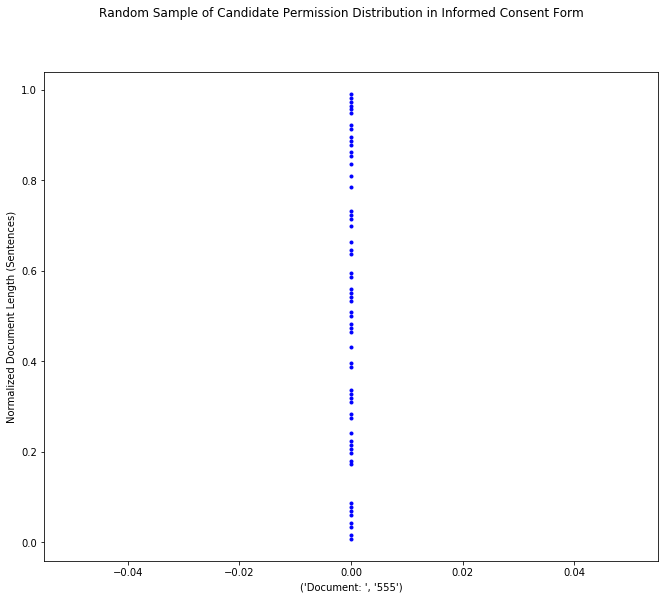

In [47]:
n_samples = 1
position_df_sample = position_df.sample(n=n_samples)

f, ax = plt.subplots(figsize=(11, 9), facecolor='w')

for i, row in position_df_sample.iterrows():
    x_axis = 'Document: ', str(row['id'])
    
    x = row['normalized_position_vector']
    y = np.zeros_like(x) + 0
    plt.plot(y, x, "b.")
    plt.suptitle('Random Sample of Candidate Permission Distribution in Informed Consent Form')
    plt.xlabel(x_axis)
    plt.ylabel('Normalized Document Length (Sentences)')

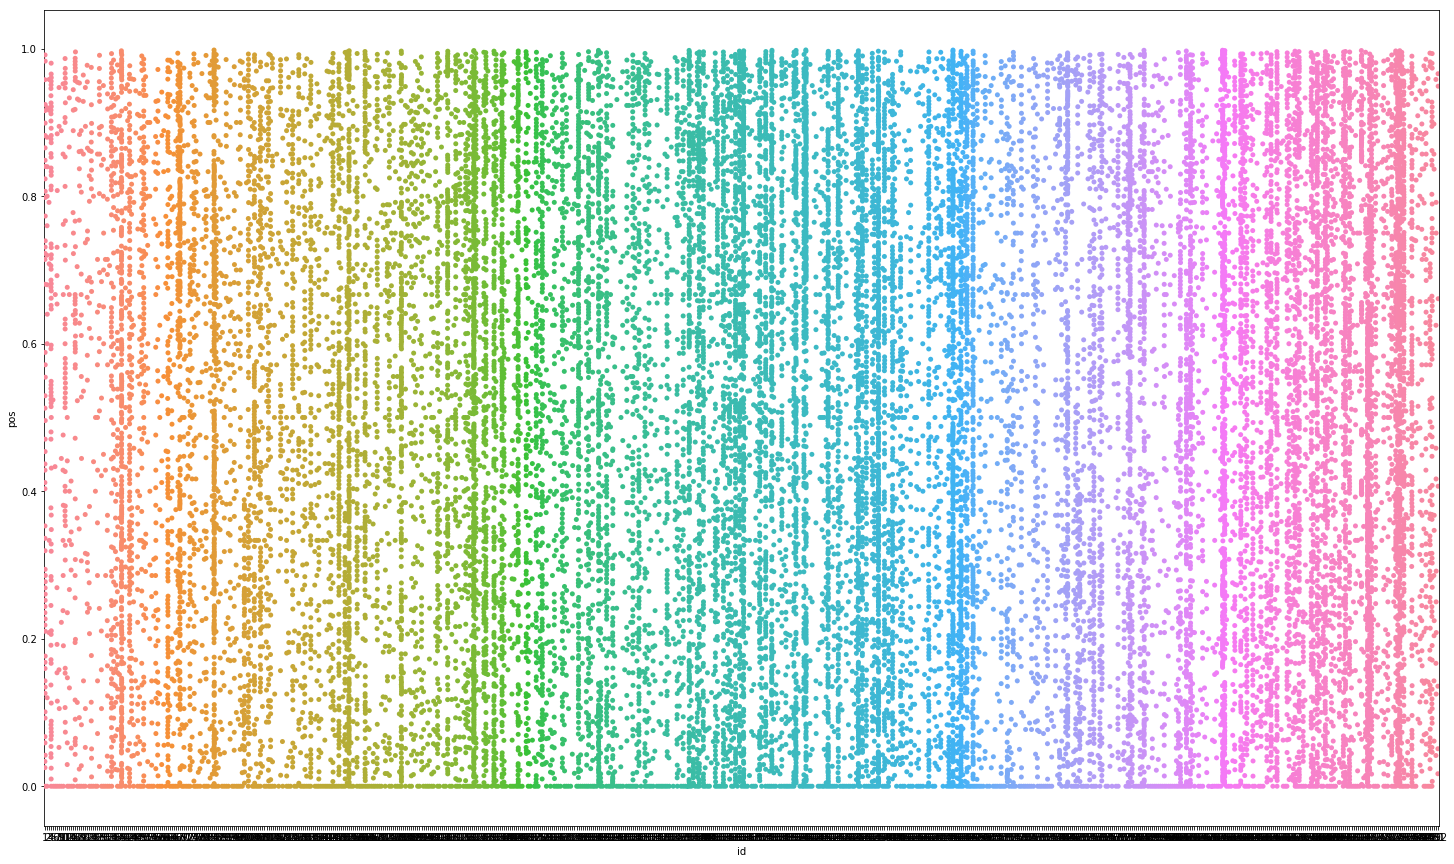

In [48]:
f, ax = plt.subplots(figsize=(25, 15), facecolor='w')
ax = sns.stripplot(x="id", y="pos", data=position_df)

## Strip Short sents again

In [49]:
getFrom = 'EXPANDED_CANDIDATES_0.95'
convertTo = getFrom + '_stripped'
secondary_sentence_length_threshold = len('i consent')

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, secondary_sentence_length_threshold),axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [50]:
for sent in df['EXPANDED_CANDIDATES_0.95_stripped'].head(2):
    print('-----------------')
    [print(x, '\n') for x in sent[:10]]

-----------------
the information in this form is provided to help you decide whether or not to take part. 

note: information about payment to participants in human research is available in sap21.01.99.mo.03 will i be paid to be in this study you will not be paid for being in this study or you will receive payment/reimbursement/participation credit. 

ask your study doctor for more information about what tests and procedures will be done. 

for student/resident research, add: you may also contact the protocol director, name of pd at xxx-xxx-xxxx or email address. for alternate contact (co-i, coordinator, etc.), add: you may also contact the research role, name of alternate contact at xxx-xxx-xxxx or email address. for questions about your rights as a research participant, to provide input regarding research, or if you have questions, complaints, or concerns about the research, you may call the texas a&m university human research protection program (hrpp) by phone at 1-979-458-4067, to

### How many are there?

In [51]:
cand_count = 0
total_count = 0

for sent in df['sentenceList']:
    total_count += len(sent)
    
for cand_sent in df['EXPANDED_CANDIDATES_0.95_stripped']:
    cand_count += len(cand_sent)

print('number of total sentences (including short sentences):', total_count)
print('number of candidate sentences:', cand_count)
print('percentage:', cand_count/total_count)

number of total sentences (including short sentences): 65595
number of candidate sentences: 24698
percentage: 0.37652260080798844


### Check DUPES

In [52]:
# df.head()

In [53]:
def removeDUPES(row):
    """  print number of unique vs total  """
    
    unique = []
    
    for sent in row['EXPANDED_CANDIDATES_0.95_stripped']:
        unique.append(sent.text)
    
    return list(set(unique))

df['UNIQUE_CANDIDATES'] = df.apply(lambda row:removeDUPES(row) ,axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [54]:
cand_count = 0
total_count = 0

for sent in df['sentenceList']:
    total_count += len(sent)
    
for cand_sent in df['UNIQUE_CANDIDATES']:
    cand_count += len(cand_sent)

print('number of total sentences (including short sentences):', total_count)
print('number of candidate sentences:', cand_count)
print('percentage:', cand_count/total_count)

number of total sentences (including short sentences): 65595
number of candidate sentences: 23834
percentage: 0.3633508651574053


## Notice how many EXACT duplicate sentences are left:

In [55]:
all_candidates = []

for candidates in df['UNIQUE_CANDIDATES']:
    for sent in candidates:
        all_candidates.append(sent)

print('total sents:', len(all_candidates))
print('unique sents:', len(set(all_candidates)))
print('exact dupes:', len(all_candidates) - len(set(all_candidates)))

total sents: 23834
unique sents: 18670
exact dupes: 5164


## Exploratory Data Analysis

In [82]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList,sentenceList_stripped,CANDIDATES,EXPANDED_CANDIDATES_0.95,EXPANDED_CANDIDATES_0.95_stripped,UNIQUE_CANDIDATES
id,,,,,,,,,,,
1,TAMU - HRPP Informed consent.txt,../data/raw/all_forms/TAMU - HRPP Informed con...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...,not intended for use without tamu/bcd irb appr...,"(not, intended, for, use, without, tamu, /, bc...","[(not, intended, for, use, without, tamu, /, b...","[(you, are, being, asked, to, be, in, this, st...","[(for, student, /, resident, research, ,, add,...","[(the, information, in, this, form, is, provid...","[(the, information, in, this, form, is, provid...",[1. when the study has no provision of treatme...
2,Potomac Primary Care_flu-consent-form.txt,../data/raw/all_forms/Potomac Primary Care_flu...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...,patient consent form for seasonal influenza va...,"(patient, consent, form, for, seasonal, influe...","[(patient, consent, form, for, seasonal, influ...","[(signature, date, insert, facility, logo, , ...","[(0.5, ml, i, m, influenza, high, dose, virus,...","[(i, understand, the, benefits, and, risks, of...","[(i, understand, the, benefits, and, risks, of...","[nurse/ma/provider s, patient consent form for..."
3,OSU_Scheduled_Delivery_Consent.txt,../data/raw/all_forms/OSU_Scheduled_Delivery_C...,SCHEDULED DELIVERY: Today’s Date: Da...,scheduled delivery: today s date: date of sche...,"(scheduled, delivery, :, today, s, date, :, da...","[(scheduled, delivery, :, today, s, date, :, d...","[(lfa, physician, desires, to, add, on, an, in...","[(#, the, ohio, state, university, medical, ce...","[(lfa, concern, exists, about, the, prioritiza...","[(lfa, concern, exists, about, the, prioritiza...",[c) medically indicated induction will be give...
4,consent_biorepository_12-19-14.txt,../data/raw/all_forms/consent_biorepository_12...,﻿ Informed Consent Form and HIPAA Authorizatio...,informed consent form and hipaa authorization ...,"(informed, consent, form, and, hipaa, authoriz...","[(informed, consent, form, and, hipaa, authori...","[(in, the, sections, that, follow, ,, the, wor...","[(do, you, need, to, give, your, consent, in, ...","[(in, the, sections, that, follow, ,, the, wor...","[(in, the, sections, that, follow, ,, the, wor...","[(initials) provided that the irb approves, i ..."
5,Cambridge_Consent_endodontics2.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,INFORMAT IONAL USE ONLY CONSENT FOR ENDODONTI...,informat ional use only consent for endodontic...,"(informat, ional, use, only, consent, for, end...","[(informat, ional, use, only, consent, for, en...","[(there, are, risks, involved, in, administrat...","[(informat, ional, use, only, consent, for, en...","[(5, ., successful, completion, of, the, root,...","[(5, ., successful, completion, of, the, root,...",[informat ional use only consent for endodonti...


In [86]:
new_rows = []

for idx, row in df.iterrows():
    
    sent_lengths_doc = []
    
    number_of_raw_sents_doc = len(row['sentenceList_stripped'])
    number_of_sents_doc = len(row['UNIQUE_CANDIDATES'])
    
    for sent in row['UNIQUE_CANDIDATES']:
        sent_lengths_doc.append(len(sent))
    
    row = {
        'name':row['name'],
        'n_candidates':number_of_sents_doc,
        'mean_sent_length': np.mean(sent_lengths_doc),
        'sent_lengths':sent_lengths_doc,
        'raw_n_sents':number_of_raw_sents_doc,
    }
    
    new_rows.append(row)
    
    
stat_frame = pd.DataFrame(new_rows)
stat_frame.head(30)

,mean_sent_length,n_candidates,name,raw_n_sents,sent_lengths
0,146.293103,58,TAMU - HRPP Informed consent.txt,118,"[243, 131, 123, 100, 152, 138, 71, 65, 232, 86..."
1,116.818182,11,Potomac Primary Care_flu-consent-form.txt,22,"[19, 174, 157, 12, 121, 91, 206, 171, 74, 173,..."
2,141.333333,6,OSU_Scheduled_Delivery_Consent.txt,23,"[56, 81, 250, 116, 251, 94]"
3,138.519481,77,consent_biorepository_12-19-14.txt,198,"[117, 72, 127, 124, 172, 197, 148, 217, 90, 94..."
4,129.000000,2,Cambridge_Consent_endodontics2.txt,17,"[163, 95]"
5,165.000000,3,Northwest_Missouri_State_University_Vaccinatio...,24,"[98, 267, 130]"
6,211.900000,10,UIowa_Patient-Treatment-Consent-Agreement.txt,26,"[96, 131, 262, 342, 152, 255, 151, 163, 305, 262]"
7,147.666667,6,Biomed_child_assent_UCSD.txt,19,"[188, 148, 230, 89, 159, 72]"
8,359.500000,4,Durango_Extraction-Consent.txt,9,"[187, 95, 46, 1110]"
9,220.333333,12,DHHS_TANSANIA_HPV_Consent.txt,19,"[158, 188, 60, 84, 194, 822, 132, 294, 143, 16..."


In [87]:
print(np.mean(stat_frame['n_candidates']))
print(np.std(stat_frame['n_candidates']))
print()
print(np.mean(stat_frame['raw_n_sents']))
print(np.std(stat_frame['raw_n_sents']))

34.146131805157594
44.787481214908155

85.09025787965616
103.84425544695179


In [92]:
no_candidates = stat_frame.loc[stat_frame['n_candidates'] == 0]
no_candidates.head(len(no_candidates))

,mean_sent_length,n_candidates,name,raw_n_sents,sent_lengths
209,NaN,0,Cambridge_Consent_extraction1.txt,6,[]
361,NaN,0,Cambridge_Consent_ivsedation1.txt,13,[]
588,NaN,0,National Network for Oral Health Access_Extrac...,11,[]
662,NaN,0,New_York_City_Health_and_Hospitals_Corporation...,6,[]
667,NaN,0,National Network for Oral Health Access_Treatm...,15,[]


## print candidate statements to file

In [57]:
# today = str(datetime.date.today())

# file_path = '../data/outputs/ALL_candidate_statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'w') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['file_id','candidate_statement'])
#     for index, row in df.iterrows():
#         for candidate in row['UNIQUE_CANDIDATES']
#             formatted_idx = "[[fileID:" + str(index) + "]]"
#             writer.writerow([formatted_idx, candidate])

### Print run metadata to file

In [58]:
# file_path = '../data/outputs/run_metadata-'+today+'.csv'
# print(file_path)

# tuneable_parameters = {
#         'preliminary sentence threshold':preliminary_sentence_length_thresh,
#         'candidate similarity threshold':sim_threshold,
#         'secondary sentence threshold':secondary_sentence_length_threshold,
# }
# with open(file_path, 'w') as outcsv: 
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['variable','value'])
    
#     for k,v in tuneable_parameters.items():
#         writer.writerow([k,v])
        

### print semantic clues to file

In [59]:
# file_path = '../data/outputs/semantic_clues-'+today+'.csv'
# print(file_path)

# with open(file_path, 'w') as outcsv: 
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['clue','definition'])
    
#     for word in permission_extended:
#         syns = wordnet.synsets(word)
#         for word_sense in syns:
#             writer.writerow([word,word_sense.definition()])

### Print file IDs to file

In [60]:
# today = str(datetime.date.today())

# file_path = '../data/outputs/file_ids-'+today+'.csv'
# print(file_path)

# with open(file_path, 'w') as outcsv: 
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['fileID','name', 'path'])
    
#     for index, row in raw_df.iterrows():
#         writer.writerow([index,row['name'], row['path']])

## print info about samples to file

In [61]:
# file_path = '../data/outputs/sample_metadata-'+today+'.csv'
# print(file_path)

# with open(file_path, 'w') as outcsv: 
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['fileID',
#                      'name', 
#                      'path', 
#                      'num_candidates',
#                      'num_sentences'])
    
#     for index, row in df.iterrows():
#         writer.writerow([index,row['name'], 
#                          row['path'], 
#                          len(row['EXPANDED_CANDIDATES_0.95_stripped']),
#                          len(row['sentenceList'])])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.